In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.12.0


In [ ]:
# All general imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer 

import keras
!pip install keras_preprocessing
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Reshape, Conv2D, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Bidirectional, GlobalAveragePooling1D, GRU, GlobalMaxPooling1D, concatenate
from keras.optimizers import Adam
from keras.layers import LSTM, GRU, Conv1D, MaxPool1D, Activation, Add

from keras.models import Model, Sequential
from keras.layers.core import SpatialDropout1D

from keras.layers import Layer, Dense, Input, Embedding, Dropout, Activation, Conv2D, MaxPooling2D, AveragePooling2D, Softmax
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import backend as K

from keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import io, os, gc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [ ]:
# Loading drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting the working directory 
!ls
%cd drive/MyDrive/Project
!pwd

drive  sample_data
/content/drive/MyDrive/Project
/content/drive/MyDrive/Project


In [ ]:
#################### Importing FNC Datasets ####################

le = LabelEncoder()
le2 = LabelEncoder()

# Train set
train_df = pd.read_csv('data/train_fnc_with_labels_2nd.csv')
print(train_df.columns)
train_df['Stance'] = le.fit_transform(train_df['Stance']) # agree = 0, disagree = 1
train_df['single_new_emo'] = le2.fit_transform(train_df['single_new_emo']) # emotions agree = 0, disagree = 1
train_df.head()

# Test set
test_df = pd.read_csv('data/test_fnc_with_labels.csv')
print(test_df.columns)
test_df['Stance'] = le.transform(test_df['Stance'])
test_df['single_new_emo'] = le2.transform(test_df['single_new_emo'])
test_df.head()

Index(['id', 'Body', 'Headline', 'Stance', 'Emotion_Labels', 'Novelty_Quora',
       'com_femotion', 'single_new_emo', 'premise_emo', 'hypothesis_emo',
       'novelty_label'],
      dtype='object')
Index(['id', 'Body', 'Headline', 'Stance', 'Emotion_Labels', 'Novelty_Quora',
       'com_femotion', 'single_new_emo', 'premise_emo', 'hypothesis_emo',
       'novelty_label'],
      dtype='object')


,id,Body,Headline,Stance,Emotion_Labels,Novelty_Quora,com_femotion,single_new_emo,premise_emo,hypothesis_emo,novelty_label
0,1964,"Last week, Apple sent out the invites for its ...",EXCLUSIVE: Apple To Unveil The Long-Awaited Re...,0,1,1,1,1,1,0,1
1,1618,Did a woman claiming to have a third breast pl...,3-Boobed Woman a Fake,0,0,0,0,0,1,1,1
2,2316,A fourth grader named Aiden Steward was suspen...,Texas Boy Suspended For 'Threatening' Classmat...,0,0,1,1,1,1,0,1
3,1452,LOS ANGELES (CBS Seattle/AP) — A scorpion stun...,Woman stung by scorpion on Alaska Airlines flight,0,0,0,0,0,1,1,1
4,1636,If the bizarre story about Joan Rivers' doctor...,Disgusting! Joan Rivers Doc Gwen Korovin’s Sic...,1,0,1,0,0,1,1,1


In [ ]:
train_lst_1 = train_df['Body'].tolist()
train_lst_2 = train_df['Headline'].tolist()
print('Train Headline: ', len(train_lst_2))
uq_tr_1 = list(set(train_lst_1))
uq_tr_2 = list(set(train_lst_2))
train_merged = uq_tr_1 + uq_tr_2
print('Train length is', len(train_merged))

test_lst_1 = test_df['Body'].tolist()
test_lst_2 = test_df['Headline'].tolist()
uq_ts_1 = list(set(test_lst_1))
uq_ts_2 = list(set(test_lst_2))
test_merged = uq_ts_1 + uq_ts_2
print('Test length is', len(test_merged))

total_dataset = train_merged + test_merged
print('Total dataset length is', len(total_dataset))

Train Headline:  3615
Train length is 1735
Test length is 961
Total dataset length is 2696


In [ ]:
train_max_1 = max([len(s) for s in train_lst_1])
train_max_2 = max([len(s) for s in train_lst_2])
train_avg_1 = int(np.average([len(s) for s in train_lst_1]))
train_avg_2 = int(np.average([len(s) for s in train_lst_2]))
train_min_1 = min([len(s) for s in train_lst_1])
train_min_2 = min([len(s) for s in train_lst_2])
print("Train set: ")
print('Body -> Max: ', train_max_1, 'Avg: ', train_avg_1, 'Min: ', train_min_1)
print('Headline -> Max: ', train_max_2, 'Avg: ', train_avg_2, 'Min: ', train_min_2)
test_max_1 = max([len(s) for s in test_lst_1])
test_max_2 = max([len(s) for s in test_lst_2])
test_avg_1 = int(np.average([len(s) for s in test_lst_1]))
test_avg_2 = int(np.average([len(s) for s in test_lst_2]))
test_min_1 = min([len(s) for s in test_lst_1])
test_min_2 = min([len(s) for s in test_lst_2])
print("Test set: ")
print('Body -> Max: ', test_max_1, 'Avg: ', test_avg_1, 'Min: ', test_min_1)
print('Headline -> Max: ', test_max_2, 'Avg: ', test_avg_2, 'Min: ', test_min_2)

MAX_LENGTH = 100

Train set: 
Body -> Max:  13580 Avg:  2093 Min:  38
Headline -> Max:  215 Avg:  68 Min:  11
Test set: 
Body -> Max:  19815 Avg:  2336 Min:  29
Headline -> Max:  186 Avg:  69 Min:  10


In [ ]:
import string
!pip install nltk
import nltk
from nltk.tokenize import  word_tokenize

contr_dict = {"I\'m": "I am",
            "won\'t": "will not",
            "\'s" : "", 
            "\'ll":"will",
            "\'ve":"have",
            "n\'t":"not",
            "\'re": "are",
            "\'d": "would",
            "y'all": "all of you",
            "\' " : " ",
            " \'" : " "}

known_typos = {
    "accordin ":"according ",
    "entirel ":"entirely ",
    "electri ":"electric"
}

def encode_char(text):
    text = text.replace(u"\u201d",'"') # replace unicode quotation
    text = text.replace(u"\u201c",'"')
    text = text.replace(u"\u2018","'")
    text = text.replace(u"\u2019","'")
    if u"\u201d" in text or u"\u201c" in text or u"\u2018" in text or u"\u2019" in text:
      print(text)
    encoded_string = text.encode("ascii", "ignore")
    text = encoded_string.decode()
    return text

def correct_typos(text):
    text = text + " "
    for typo in known_typos:
      text = text.replace(typo, " "+known_typos[typo])
    return text

def remove_html(text):
    text = text.replace("< i >", "")
    text = text.replace("< / i >", "")
    return text

def remove_numbers(text):
    no_digits = ""
    for i in text:
        if not i.isdigit():
            no_digits += i
    return no_digits

def remove_punctuation(text):
    punctuationfree = ""
    for i in range(len(text)):
      if text[i] not in string.punctuation:
        punctuationfree += text[i]
      else:
        if i < (len(text)-1) and text[i+1] != " ": # add space after punctuation
          punctuationfree += " "
    return punctuationfree

def tokenization(text):
    tokens = word_tokenize(text)
    return tokens

def remove_stopwords(stopwords, tokens):
    result = [t for t in tokens if t not in stopwords]
    return result

def tokens_to_text(tokens):
    result = " ".join(t for t in tokens)
    return result

# remove apostrophes and replaces contractions with full words
def replace_contractions(text, contr_dict=contr_dict):
    text = text.lower()
    for char in ["′","ʼ","`","՚","ʼ","ߴ","ߵ","＇", '“','”',"\'", "’", "‘"]:
      text = text.replace(char, "\'")
    for i in range(len(text)):
      if text[i] == "\'" and (i == 0 or text[i-1] == "."):
        text[i] == ""
    text = text.replace(" \'"," ")
    text = text.replace("\' "," ")
    for contr in contr_dict:
      text = text.replace(contr, " "+contr_dict[contr])
    text = text.replace("\'","")
    return text

def text_preprocessing(texts):
  new_texts = []
  for text in texts:
      text = encode_char(text)
      # text = remove_html(text)
      text = remove_numbers(text)
      text = replace_contractions(text)
      # text = remove_punctuation(text)
      text = correct_typos(text)
      # tokens =  tokenization(text)
      # stopwords = nltk.corpus.stopwords.words('english')
      # tokens = remove_stopwords(stopwords, tokens)
      # text = tokens_to_text(tokens)
      new_texts.append(text)
  return new_texts

total_dataset = text_preprocessing(total_dataset)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from nltk import tokenize
import nltk
nltk.download('punkt')

n_sent_lst = []
n_words_lst = []
for text in total_dataset: # count max number of sentences and max number of words in a sentence
  sentences = tokenize.sent_tokenize(text)
  n_sent_lst.append(len(sentences))
  n_words = 0
  for sent in sentences:
    n = len(tokenize.word_tokenize(sent))
    if n > n_words:
      n_words = n
  n_words_lst.append(n_words)

max_n_sent = max(n_sent_lst)
max_n_words = max(n_words_lst)

print(max_n_sent) # max num of sentences
print(max_n_words) # max num of words in a sentence

if max_n_sent > 10:
  m = 10
elif max_n_sent >= 5:
  m = max_n_sent
else:
  m = 5

if max_n_words > 50:
  n = 50
elif max_n_words >= 10:
  n = max_n_words
else:
  n = 10

#MAX_LENGTH = m*n
MAX_LENGTH = 150
print(MAX_LENGTH)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


159
348
150


In [ ]:
# Defining the tokenizer
def get_tokenizer(vocabulary_size):
  print('Training tokenizer...')
  tokenizer = Tokenizer(num_words = vocabulary_size)
  tweet_text = []
  print('Read {} Sentences'.format(len(total_dataset)))
  tokenizer.fit_on_texts(total_dataset)
  return tokenizer

In [ ]:
def process_glove_line(line, dim):
    word = None
    embedding = None
    try:
      splitLine = line.split()
      word = " ".join(splitLine[:len(splitLine)-dim])
      embedding = np.array([float(val) for val in splitLine[-dim:]])
    except:
      print(line)
    return word, embedding

# For getting the embedding matrix
def get_embeddings():
  print('Generating embeddings matrix...')
  embeddings_file = 'glove.6B.300d.txt'
  embeddings_index = dict()
  with open(embeddings_file, 'r', encoding="utf-8") as infile:
    for line in infile:
      word, vector = process_glove_line(line, 300)
      embeddings_index[word] = vector
	# create a weight matrix for words in training docs
  vocabulary_size = len(embeddings_index)
  embeddinds_size = list(embeddings_index.values())[0].shape[0]
  print('Vocabulary = {}, embeddings = {}'.format(vocabulary_size, embeddinds_size))
  tokenizer = get_tokenizer(vocabulary_size)
  embedding_matrix = np.zeros((vocabulary_size, embeddinds_size))
  considered = 0
  total = len(tokenizer.word_index.items())
  oov = []
  for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
      print(word, index)
      continue
    else:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        considered += 1
      else:
         oov.append(word)
  print('Considered ', considered, 'Left ', total - considered)	
  return embedding_matrix, tokenizer, embeddings_index, oov

In [ ]:
def get_data(tokenizer, MAX_LENGTH, input_df):
  print('Loading data')
  X1, X2, Y = [], [], []
  X1 = input_df['Body'].tolist()
  X2 = input_df['Headline'].tolist()
  X1 = text_preprocessing(X1)
  X2 = text_preprocessing(X2)
  Y_fnc = input_df['Stance'].tolist()
  Y_nv = input_df["novelty_label"].values
  Y_em = input_df["single_new_emo"].values
  # Y_nv = input_df["Novelty_Quora"].values
  # Y_em = input_df["com_femotion"].values
  assert len(X1) == len(X2) == len(Y_fnc) == len(Y_nv) == len(Y_em)
  sequences_1 = tokenizer.texts_to_sequences(X1)
  sequences_2 = tokenizer.texts_to_sequences(X2)
  X1 = pad_sequences(sequences_1, maxlen=MAX_LENGTH)
  X2 = pad_sequences(sequences_2, maxlen=MAX_LENGTH)
  Y_fnc = np.array(Y_fnc)
  Y_nv = np.array(Y_nv)
  Y_em = np.array(Y_em)
  return X1, X2, Y_fnc, Y_nv, Y_em

In [ ]:
embedding_matrix, tokenizer, embeddings_index, oov = get_embeddings()

Generating embeddings matrix...
Vocabulary = 400000, embeddings = 300
Training tokenizer...
Read 2696 Sentences
Considered  20088 Left  1759


In [ ]:
#print(tokenizer.word_index)

In [ ]:
def get_oov_freq(oov, total_dataset):
  oov_freq = dict()
  for s in total_dataset:
    for word in oov:
      count = s.count(word)
      if count > 0:
        try:
          oov_freq[word] += count
        except KeyError:
          oov_freq[word] = count
  return oov_freq

def show_oov_words(oov_freq, num_to_show=30):
    # Sort oov words by their frequency in the text
    sorted_oov = sorted(oov_freq.items(), key=lambda x:x[1], reverse=True)
    # Show oov words and their frequencies
    if (len(sorted_oov)>0):
        print("oov words:")
        for pair in sorted_oov[:num_to_show]:
          print("%s\t%s"%(pair[0], pair[1]))
    else:
        print("No words were out of vocabulary.")
    return len(sorted_oov)

In [ ]:
# oov_freq = get_oov_freq(oov, total_dataset)
# oov_len = show_oov_words(oov_freq, 100)

In [ ]:
# read train data
X1, X2, Y_fnc, Y_nv, Y_em = get_data(tokenizer, MAX_LENGTH, train_df)

Loading data


Class balance for train data: 


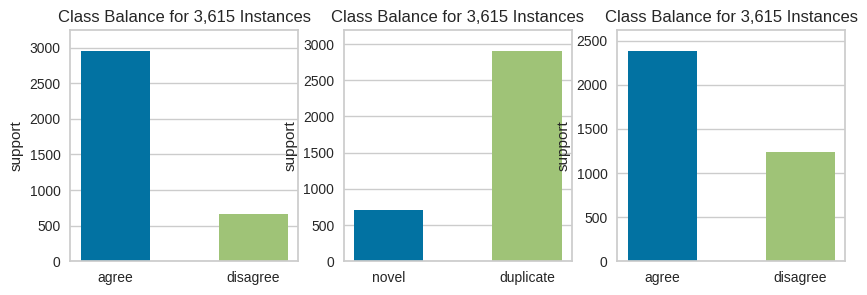

In [ ]:
#!pip install yellowbrick
from yellowbrick.target import ClassBalance
import matplotlib.pyplot as plt

print("Class balance for train data: ")
fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(10,3))

classes = le.inverse_transform(np.arange(2))
classes2 = le2.inverse_transform(np.arange(2))

visualiser_fnc = ClassBalance(labels=classes, ax=ax1)
visualiser_fnc.fit(Y_fnc)
visualiser_fnc.finalize()

visualiser_nv = ClassBalance(labels=['novel', 'duplicate'], ax=ax2) # 0 = novel, 1 = duplicate
visualiser_nv.fit(Y_nv)
visualiser_nv.finalize()

visualiser_em = ClassBalance(labels=classes2, ax=ax3) # 0 = agree, 1 = disagree
visualiser_em.fit(Y_em)
visualiser_em.finalize()

In [ ]:
print("FNC train data class balance: ")
unique, counts = np.unique(Y_fnc, return_counts=True)
dict(zip(unique, counts))

FNC train data class balance: 


{0: 2948, 1: 667}

In [ ]:
# read test data
X1_test, X2_test, Y_fnc_test, Y_nv_test, Y_em_test = get_data(tokenizer, MAX_LENGTH, test_df)

Loading data


Class distribution for test data: 


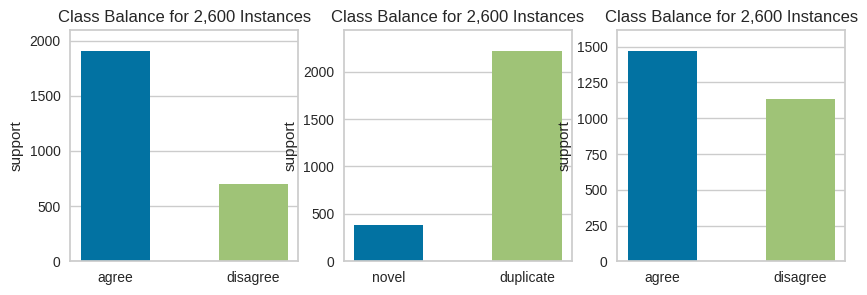

In [ ]:
print("Class distribution for test data: ")
fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(10,3))
classes = le.inverse_transform(np.arange(2))
classes2 = le2.inverse_transform(np.arange(2))

visualiser_fnc = ClassBalance(labels=classes, ax=ax1)
visualiser_fnc.fit(Y_fnc_test)
visualiser_fnc.finalize()

visualiser_nv = ClassBalance(labels=['novel', 'duplicate'], ax=ax2)
visualiser_nv.fit(Y_nv_test)
visualiser_nv.finalize()

visualiser_em = ClassBalance(labels=classes2, ax=ax3)
visualiser_em.fit(Y_em_test)
visualiser_em.finalize()

In [ ]:
print("FNC test data class balance: ")
unique, counts = np.unique(Y_fnc_test, return_counts=True)
dict(zip(unique, counts))

FNC test data class balance: 


{0: 1903, 1: 697}

In [ ]:
# Creating one-hot encodings
y_train_nv = keras.utils.to_categorical(Y_nv)
# print(y_train_nv)
y_train_em = keras.utils.to_categorical(Y_em)
# print(y_train_em)
y_train_fnc = keras.utils.to_categorical(Y_fnc)
# print(y_train_fnc)
y_test_nv = keras.utils.to_categorical(Y_nv_test)
# print(y_test_nv)
y_test_em = keras.utils.to_categorical(Y_em_test)
# print(y_test_em)
y_test_fnc = keras.utils.to_categorical(Y_fnc_test)
# print(y_test_fnc)

In [ ]:
from sklearn.model_selection import train_test_split
VALIDATION_RATIO = 0.1
RANDOM_STATE = 9527
x1_train, x1_val, \
x2_train, x2_val, \
y_train_nv, y_val_nv, \
y_train_em, y_val_em, \
y_train_fnc, y_val_fnc = \
    train_test_split(
        X1, X2, 
        y_train_nv, y_train_em, 
        y_train_fnc,
        test_size=VALIDATION_RATIO, 
        random_state=RANDOM_STATE
)

In [ ]:
print("Training Set")
print("-" * 10)
print(f"x1_train: {x1_train.shape}")
print(f"x2_train: {x2_train.shape}")
# print(f"x1_train_bert : {x1_train_bert.shape}")
# print(f"x2_train_bert : {x2_train_bert.shape}")

print("-" * 10)
print(f"x1_val:   {x1_val.shape}")
print(f"x2_val:   {x2_val.shape}")
# print(f"x1_val_bert:   {x1_val_bert.shape}")
# print(f"x2_val_bert :   {x2_val_bert.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x1_train: (3253, 150)
x2_train: (3253, 150)
----------
x1_val:   (362, 150)
x2_val:   (362, 150)
----------
Test Set


In [ ]:
NUM_CLASSES = 2

MAX_SEQUENCE_LENGTH = MAX_LENGTH

NUM_LSTM_UNITS = 150

MAX_NUM_WORDS = embedding_matrix.shape[0]

NUM_EMBEDDING_DIM = embedding_matrix.shape[1]

In [ ]:
################# Disagreement detection using LSTM ##################

pre_input = Input( # lstm for premise
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')
hyp_input = Input( # lstm for hypothesis
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

# Embedding layer
embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM, weights = [embedding_matrix], trainable = True)
pre_embedded = embedding_layer(pre_input)
hyp_embedded = embedding_layer(hyp_input)

# LSTM
shared_lstm = LSTM(NUM_LSTM_UNITS, recurrent_dropout = 0.3, name="lstm_0")
pre_lstm_output = shared_lstm(pre_embedded)
hyp_lstm_output = shared_lstm(hyp_embedded)

# Concatenating hidden representations of premise and hypothesis
comb_pre_hyp = concatenate([pre_lstm_output, hyp_lstm_output],axis=-1) # (None, 100, 600)

# Dense layer
dense_out = Dense(units=64, activation='tanh', name = 'dense_0')(comb_pre_hyp)

# Classification layer
predictions =  Dense(units=NUM_CLASSES, activation='softmax',name = 'dense_1')(dense_out)

model_lstm_dg = Model(
    inputs=[pre_input, hyp_input], 
    outputs=predictions)

model_lstm_dg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 300)     120000000   ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm_0 (LSTM)                  (None, 150)          270600      ['embedding[0][0]',          

In [ ]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
lr = 0.001
opt = Adam(lr=lr, decay=lr/50)
model_lstm_dg.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='fnc_lstm_disagreement.h5', verbose=1, save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# LSTM for disagreement detection
BATCH_SIZE = 256
NUM_EPOCHS = 50
stop = [EarlyStopping(monitor='val_loss', patience=0.001)]
history = model_lstm_dg.fit(x=[x1_train, x2_train],
                    y=y_train_fnc,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(
                      [x1_val, x2_val], 
                      y_val_fnc
                    ),
                    shuffle=True,
                    callbacks=stop,
          )

Epoch 1/50
13/13 [==============================] - 21s 1s/step - loss: 0.4964 - accuracy: 0.7762 - val_loss: 0.4431 - val_accuracy: 0.8232
Epoch 2/50
13/13 [==============================] - 14s 1s/step - loss: 0.3754 - accuracy: 0.8300 - val_loss: 0.3906 - val_accuracy: 0.8260
Epoch 3/50
13/13 [==============================] - 16s 1s/step - loss: 0.3028 - accuracy: 0.8620 - val_loss: 0.3673 - val_accuracy: 0.8370
Epoch 4/50
13/13 [==============================] - 16s 1s/step - loss: 0.2471 - accuracy: 0.8869 - val_loss: 0.3706 - val_accuracy: 0.8343


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
predictions = model_lstm_dg.predict(
    [X1_test, X2_test])

82/82 [==============================] - 11s 135ms/step


In [ ]:
# Result Labels
res_df = pd.DataFrame()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    
    # Loss
    fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
    losses = ['loss','val_loss']
    i = 0
    for ax in [ax1, ax2]:
      ax.plot(history.history[losses[i]], 'g')
      ax.set_title(losses[i])
      ax.set_xlabel('epochs')
      ax.set_ylabel(losses[i])
      i += 1
   
    plt.show()

    # Accuracy
    fig, ((ax1, ax2)) = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
    accuracies = ['accuracy','val_accuracy']
    i = 0
    for ax in [ax1, ax2]:
      ax.plot(history.history[accuracies[i]], 'b')
      ax.set_title(accuracies[i])
      ax.set_xlabel('epochs')
      ax.set_ylabel(accuracies[i])
      i += 1
   
    plt.show()

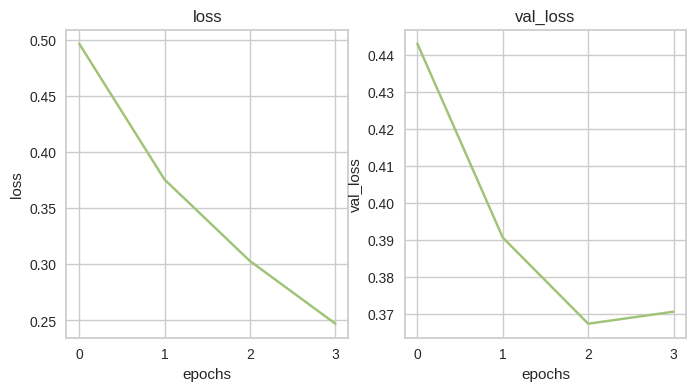

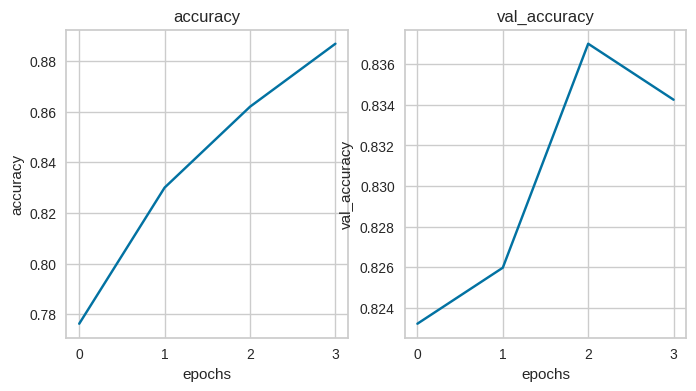

In [ ]:
#print(history.history['bd_loss'])
plot_history(history)

In [ ]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
y_pred = [idx for idx in np.argmax(predictions, axis=1)]
res_df['DG_Labels'] = y_pred
#print(y_pred)
print('BD Accuracy is')
print(metrics.accuracy_score(Y_fnc_test, y_pred)*100)
print(classification_report(Y_fnc_test, y_pred, target_names = ['agreed', 'disagreed']))

BD Accuracy is
73.46153846153847
              precision    recall  f1-score   support

      agreed       0.74      0.98      0.84      1903
   disagreed       0.54      0.06      0.12       697

    accuracy                           0.73      2600
   macro avg       0.64      0.52      0.48      2600
weighted avg       0.69      0.73      0.65      2600



[[1865   38]
 [ 652   45]]


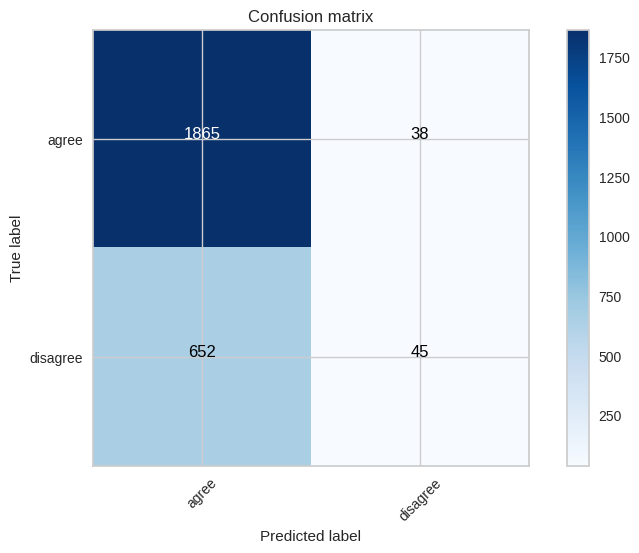

In [ ]:
cnf_matrix = confusion_matrix(Y_fnc_test,y_pred)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=le.inverse_transform(np.arange(2)))

In [ ]:
################# Emotion recognition using LSTM ##################

pre_input_em = Input( # lstm for premise
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')
hyp_input_em = Input( # lstm for hypothesis
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

# Embedding layer
embedding_layer = Embedding(MAX_NUM_WORDS, NUM_EMBEDDING_DIM, weights = [embedding_matrix], trainable = True)
pre_embedded_em = embedding_layer(pre_input_em)
hyp_embedded_em = embedding_layer(hyp_input_em)

# LSTM
shared_lstm = LSTM(NUM_LSTM_UNITS, recurrent_dropout = 0.3, name="lstm_em_0")
pre_lstm_output_em = shared_lstm(pre_embedded_em)
hyp_lstm_output_em = shared_lstm(hyp_embedded_em)

# Concatenating hidden representations of premise and hypothesis
comb_pre_hyp_em = concatenate([pre_lstm_output_em, hyp_lstm_output_em],axis=-1) # (None, 100, 600)

# Dense layer
dense_out_em = Dense(units=64, activation='tanh', name = 'dense_em_0')(comb_pre_hyp_em)

# Classification layer
predictions_em =  Dense(units=NUM_CLASSES, activation='softmax',name = 'dense_em_1')(dense_out_em)

model_lstm_em = Model(
    inputs=[pre_input_em, hyp_input_em], 
    outputs=predictions_em)

model_lstm_em.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 150, 300)     120000000   ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 lstm_em_0 (LSTM)               (None, 150)          270600      ['embedding_2[0][0]',      

In [ ]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
lr = 0.001
opt = Adam(lr=lr, decay=lr/50)
model_lstm_em.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='fnc_lstm_emotion.h5', verbose=1, save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# LSTM for emotion recognition
BATCH_SIZE = 256
NUM_EPOCHS = 50
stop = [EarlyStopping(monitor='val_loss', patience=0.001)]
history = model_lstm_em.fit(x=[x1_train, x2_train],
                    y=y_train_em,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(
                      [x1_val, x2_val], 
                      y_val_em
                    ),
                    shuffle=True,
                    callbacks=stop,
          )

Epoch 1/50
13/13 [==============================] - 27s 2s/step - loss: 0.6115 - accuracy: 0.6914 - val_loss: 0.5213 - val_accuracy: 0.7320
Epoch 2/50
13/13 [==============================] - 14s 1s/step - loss: 0.4308 - accuracy: 0.8048 - val_loss: 0.3745 - val_accuracy: 0.8398
Epoch 3/50
13/13 [==============================] - 15s 1s/step - loss: 0.3038 - accuracy: 0.8780 - val_loss: 0.3182 - val_accuracy: 0.8757
Epoch 4/50
13/13 [==============================] - 15s 1s/step - loss: 0.2024 - accuracy: 0.9265 - val_loss: 0.3024 - val_accuracy: 0.9116
Epoch 5/50
13/13 [==============================] - 15s 1s/step - loss: 0.1445 - accuracy: 0.9567 - val_loss: 0.3188 - val_accuracy: 0.9116


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
predictions_em = model_lstm_em.predict(
    [X1_test, X2_test])

82/82 [==============================] - 10s 115ms/step


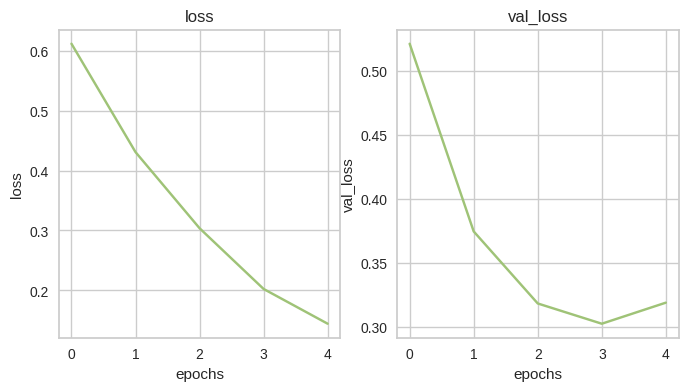

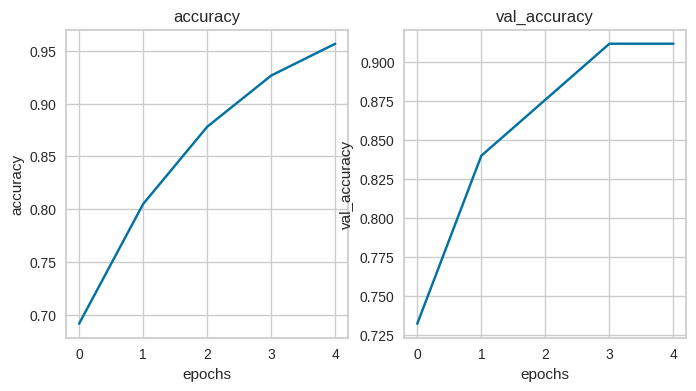

In [ ]:
plot_history(history)

In [ ]:
y_pred_em = [idx for idx in np.argmax(predictions_em, axis=1)]
res_df['EM_Labels'] = y_pred_em
print('Emotion Accuracy is')
print(metrics.accuracy_score(Y_em_test, y_pred_em)*100)
print(classification_report(Y_em_test, y_pred_em, target_names = ['agreed', 'disagreed']))

Emotion Accuracy is
61.80769230769231
              precision    recall  f1-score   support

      agreed       0.64      0.73      0.68      1468
   disagreed       0.57      0.48      0.52      1132

    accuracy                           0.62      2600
   macro avg       0.61      0.60      0.60      2600
weighted avg       0.61      0.62      0.61      2600



[[1067  401]
 [ 592  540]]


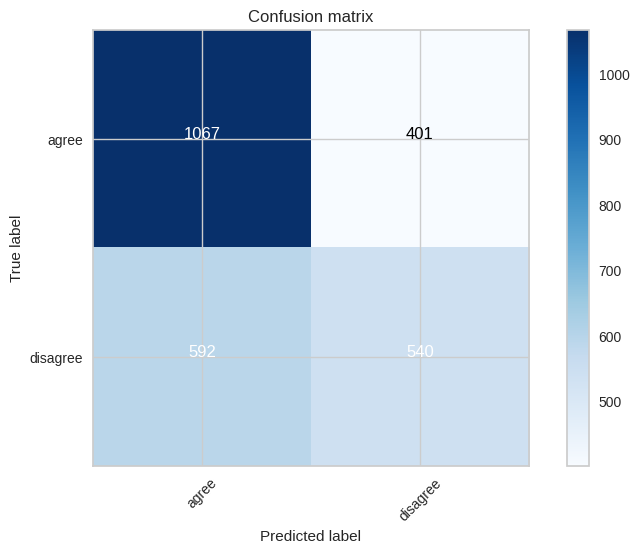

In [ ]:
cnf_matrix = confusion_matrix(Y_em_test,y_pred_em)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,classes=le2.inverse_transform(np.arange(2)))

In [ ]:
# Saving the labels
res_df.to_csv("baselines/outputs/FNC_Baseline_LSTM_results.csv", index = False)